In [1]:
import numpy as np
import random
import time
import sys
#import kali.csvLC
#import kali.carma
import matplotlib as mpl
import matplotlib.pyplot as plt
#import imp
#imp.reload(mpl); imp.reload(plt);
%matplotlib inline

In [2]:
import richardsplot as rplot

# Works well for low N, sparse time series, now testing run time for High N with missing values

In [3]:
def discreteacf(t,y,binning = False, Nbins = 100):
    """
    computes a binned ACF for irregular lightcurves or time series
    t = time array (even grid is not necessary)
    y = fluxes or magnitudes
    """
    
    #t = data[0,:]
    #y = data[1,:]
    avg = np.mean(y)
    sigma = np.std(y)
    indexP = 0
    N = len(t)
    acf = np.array([])
    P = np.zeros(shape = [2, (N-1)*N])
    start_time = time.time()
    for n in range(0, len(t)):
        #speed up this inner loop
        for k in range(0,len(t)-n):
            product = (y[n]-avg)*(y[n+k]-avg)
            dt = t[n+k]-t[n]
            P[:,indexP] = np.array([product,dt])
            indexP += 1
    end_time = time.time()
    print('time:', end_time- start_time)
    #sort for a speedboost        
    sortedP = np.sort(P[:,P[1,:]!= 0], axis = 0)
    if binning == True:
        print("binning")
        #replace histogram function with unitary function
        counts = plt.hist(wfd[0,:],bins = 300)
        bin_edges = counts[1]
        divide = np.array(counts[0])
        # condition below fixes divide by zero, numerator will still be zero for bins with zero observations
        divide[divide==0] = 1
        for i in range(0, len(bin_edges)-1):
            dt = sortedP[1, :]
            mask = ( (dt < bin_edges[i+1]) &  (dt > bin_edges[i]))
            Sum = np.sum(sortedP[0, mask])
            acf = np.append(acf, Sum/divide[i])
        ACF = acf
        return ACF, bin_edges , P    
    else:
        ACF = P
        return ACF
    

# testing map function in cell block below to replace nested for loop above

In [70]:
# code not working!!! yet...
y = wfd[1,:]
t = wfd[0,:]
avg = np.mean(y[:300])
N = len(t)
P = np.zeros(shape = [2, (N-1)*N])
indexP = 0
start_time = time.time()

def productACF(t,y):
    result =[[(y[n]-avg)*(y[n+k]-avg), (t[n+k]-t[n])] for k in np.arange(0,len(t)-n)]
    return result

result = map(productACF(t,y),np.arange(0,len(t)))
#P[:,indexP:(indexP+len(result))] = np.array(np.matrix(result).T)
#indexP = len(result)
print np.shape(result)
end_time = time.time()
print(end_time- start_time)    

TypeError: 'list' object is not callable

---
# testing a functional form for the inner loop calculation without a for loop

In [11]:
def inner(t,y,n, avg):
    """
    Optimization of the inner loop
    """
    # calculate shifts between time
    dt = t - t[n]
    
    # create mask to only include the entries where 
    mask = np.where(dt >= 0)
    
    # calculte product
    product = (y[n]-avg)*(y-avg)
    
    #apply mask
    dt = dt[mask]
    product=product[mask]
    
    return np.array([product,dt])

def discreteacf_2(t,y,binning = False, Nbins = 100):
    """
    computes a binned ACF for irregular lightcurves or time series
    args:
        t = time array (even grid is not necessary)
        y = fluxes or magnitudes
        binning = whether to bin acf (for irregular time arrays)
    
    outputs:
        acf = autocorrelation function
    
    """
    avg = np.mean(y)
    sigma = np.std(y)
    indexP = 0
    N = len(t)
    acf = np.array([])
    P = np.zeros(shape = [2, (N-1)*N])
    start_time = time.time()
    for n in range(0, len(t)):
        #removed inner loop
        temp = inner(t,y,n,avg)
        P[:,indexP:indexP+temp.shape[1]] = temp # write to P array
        indexP += temp.shape[1] # update indexing
    
    # timing the loop
    end_time = time.time()
    print('runtime:', end_time- start_time)
    
    #sort for a speedboost 
    sortedP = np.sort(P[:,P[1,:]!= 0], axis = 0)
    if binning == True:
        print("binning")
        #replace histogram function with unitary function
        counts = plt.hist(wfd[0,:],bins = 300)
        bin_edges = counts[1]
        divide = np.array(counts[0])
        # condition below fixes divide by zero, numerator will still be zero for bins with zero observations
        divide[divide==0] = 1
        for i in range(0, len(bin_edges)-1):
            dt = sortedP[1, :]
            mask = ( (dt < bin_edges[i+1]) &  (dt > bin_edges[i]))
            Sum = np.sum(sortedP[0, mask])
            acf = np.append(acf, Sum/divide[i])
        return acf, bin_edges , P   
    else:
        return P

In [5]:
# create test time series data
x,y = np.arange(200), np.random.random(200)+np.sin(np.arange(200))

In [16]:
a = discreteacf(x,y)    

('time:', 0.0464169979095459)


In [17]:
b = discreteacf_2(x,y)

('time:', 0.004951000213623047)


In [18]:
# check if output is the same
(a!=b).sum() #want this to be zero

0

The outputs match! And the second function is almost an order of magnitude faster!

---
# Load time series here

In [14]:
#import your data here
ddf = np.loadtxt('/Users/Jackster/Dropbox/ddfCadenceLC_dho_real.txt')
wfd = np.loadtxt('/Users/Jackster/Dropbox/wfdCadenceLC_dho_real.txt')

# Run the discrete ACF function with binning

0.0415029525757
binning


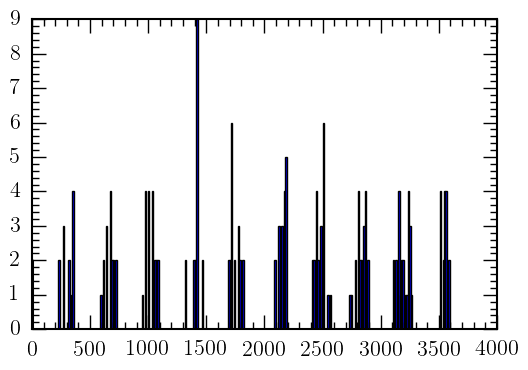

In [44]:
ACFwfd, bin_edgeswfd, pWFD = discreteacf(wfd[0,:],wfd[1,:],binning = True)
ACFddf, bin_edgesddf, pDDF = discreteacf(ddf[0,:],ddf[1,:],binning = True)


# LSST Wide Fast Deep Cadence

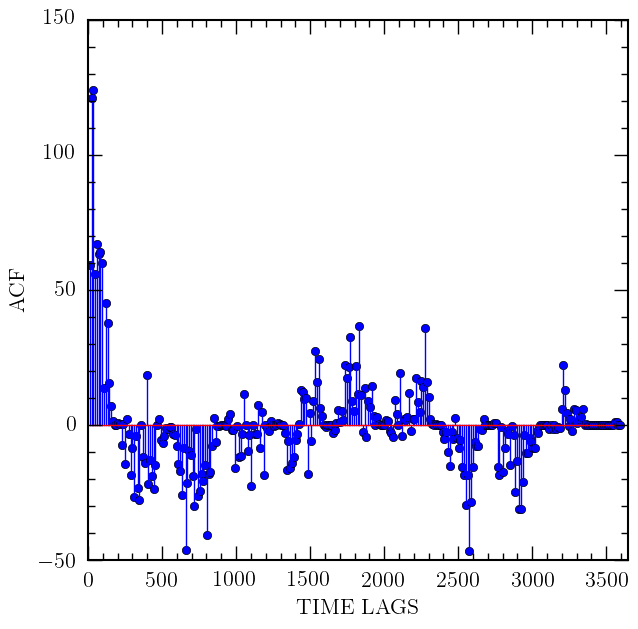

In [30]:
#plt.stem(bin_edgeswfd[1:],ACFwfd/ACFwfd.max(), color = "orange", alpha = 0.5)
plt.stem(bin_edgeswfd[1:],ACFwfd, color = "orange", alpha = 0.5)

#plt.stem(bin_edgesddf[1:],ACFddf/ACFddf.max(), color = 'darkblue', alpha = 0.5)
plt.xlim(0,365*10)
plt.ylabel('ACF')
plt.xlabel('TIME LAGS')

# LSST Deep Drilling Field 

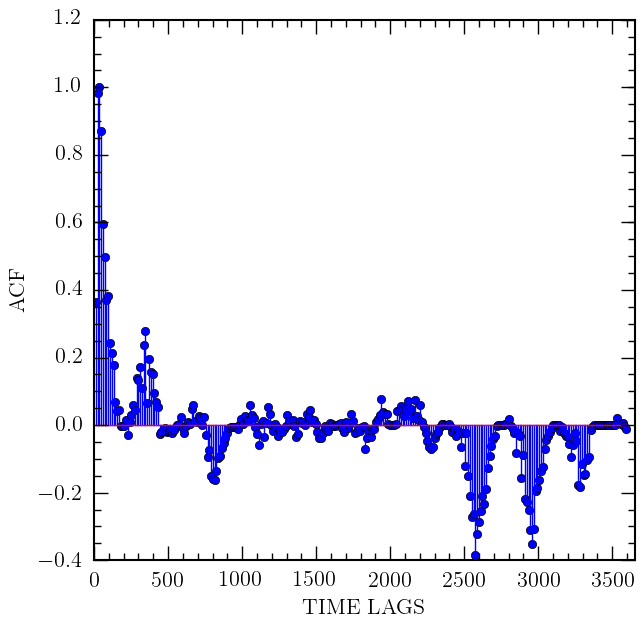

In [27]:
plt.stem(bin_edgesddf[1:],ACFddf/ACFddf.max(), color = 'darkblue', alpha = 0.5)
plt.xlim(0,365*10)
plt.ylabel('ACF')
plt.xlabel('TIME LAGS')